# Configuration

In [1]:
from secScraper import *
import sys

if sys.version_info[0] < 3 or sys.version_info[1] < 6:
    raise Exception("Must be using Python >= 3.6 due to reliance on ordered default dict.")
else:
    version = "[INFO] Running python {}.{}.{}".format(*sys.version_info[:3])
    if display.run_from_ipython():
        %load_ext autoreload
        %autoreload 2
        %matplotlib notebook
        version += " for ipython" if display.run_from_ipython() else ""
    print("[INFO] Running python {}.{}.{} (>= python 3.6)".format(*sys.version_info[:3]))

[INFO] Running python 3.7.3 (>= python 3.6)


## Packages to import

In [2]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd
import argparse
import psycopg2
import ast
import copy

# Spark
# import findspark
# findspark.init('/home/alex/spark-2.4.4-bin-hadoop2.7')
import pyspark

### Set the nb of processes to use based on cmd line arguments/setting

In [3]:
if display.run_from_ipython():
    nb_processes_requested = mp.cpu_count()  # From IPython, fixed setting
    # nb_processes_requested = 1 # From IPython, fixed setting
else:
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--processes", type=int, default=mp.cpu_count(), help="Number of processes launched to process the reports.")
    args = vars(ap.parse_args())
    nb_processes_requested = args["processes"]
    if not 1 <= nb_processes_requested <= mp.cpu_count():
        raise ValueError('[ERROR] Number of processes requested is incorrect.\
                         \n{} CPUs are available on this machine, please select a number of processes between 1 and {}'
                         .format(mp.cpu_count()))

## Settings dictionary

In [4]:
home = os.path.expanduser("~")
_s = {
    'path_stage_1_data': os.path.join(home, 'Desktop/filtered_text_data/nd_data/'),
    'path_stock_database': os.path.join(home, 'Desktop/Insight project/Database/Ticker_stock_price.csv'),
    'path_filtered_stock_data': os.path.join(home, 'Desktop/Insight project/Database/filtered_stock_data.csv'),
    'path_stock_indexes': os.path.join(home, 'Desktop/Insight project/Database/Indexes/'),
    'path_filtered_index_data': os.path.join(home, 'Desktop/Insight project/Database/Indexes/filtered_index_data.csv'),
    'path_lookup': os.path.join(home, 'Desktop/Insight project/Database/lookup.csv'),
    'path_filtered_lookup': os.path.join(home, 'Desktop/Insight project/Database/filtered_lookup.csv'),
    'path_master_dictionary': os.path.join(home, 'Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv'),
    'path_dump_crsp': os.path.join(home, 'Desktop/Insight project/Database/dump_crsp_merged.txt'),
    'path_output_folder': os.path.join(home, 'Desktop/Insight project/Outputs'),
    'path_dump_cik_scores': os.path.join(home, 'Desktop/Insight project/Outputs/dump_cik_scores.csv'),
    'path_dump_pf_values': os.path.join(home, 'Desktop/Insight project/Outputs/dump_pf_values.csv'),
    'path_dump_master_dict': os.path.join(home, 'Desktop/Insight project/Outputs/dump_master_dict.csv'),
    'metrics': ['diff_jaccard', 'diff_sk_cosine_tf_idf', 'diff_gfg_editDistDP'],
    'stop_words': False,
    'lemmatize': False,
    'differentiation_mode': 'quarterly',
    'pf_balancing': 'unbalanced',
    'time_range': [(2012, 1), (2018, 4)],
    'bin_count': 5,
    'tax_rate': 0,
    'histogram_date_span_ratio': 0.5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [5]:
_s['pf_init_value'] = 100.0  # In points
_s['epsilon'] = 0.001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Create diff metrics and sing metrics
_s['diff_metrics'] = [m for m in _s['metrics'] if m[:4] == 'diff']
_s['sing_metrics'] = [m for m in _s['metrics'] if m[:4] == 'sing']
# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'quarterly':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']

_s['common_quarterly_sections'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
"""_s['common_yearly_sections'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}"""
_s['common_yearly_sections'] = {
    '10-K': ['7'],
    '10-Q': ['_i_2']
}  # Take into account 

In [6]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

In [7]:
connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

In [8]:
postgres.settings_to_postgres(connector, s)

  0%|          | 0/35 [00:00<?, ?it/s]

[INFO] Deleted table settings
[INFO] Creating the following table:
CREATE TABLE settings(IDX integer PRIMARY KEY,KEY text,VALUE text)


100%|██████████| 35/35 [00:00<00:00, 1456.08it/s]


## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Load the sentiment analysis dictionary

In [9]:
lm_dictionary = Load_MasterDictionary.load_masterdictionary(s['path_master_dictionary'], True)

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  /home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



### Find all the unique CIK from the SEC filings

In [10]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 395,773 10-X
[INFO] Shrunk to 350,283 ['10-K', '10-Q']


 24%|██▍       | 84010/350283 [00:00<00:00, 840094.79it/s]

[INFO] Found 18,009 unique CIK in master index


100%|██████████| 350283/350283 [00:00<00:00, 876669.80it/s]

[INFO] cik_path contains data on 18,009 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [11]:
lookup, reverse_lookup = postgres.retrieve_lookup(connector)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

SELECT * FROM lookup;
[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [12]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 9,547 CIK | lookup: 9,547 CIK


### Load stock data and drop all CIKs for which we don't have data

In [13]:
# Load all stock prices
stock_data = postgres.retrieve_all_stock_data(connector, 'stock_data')

SELECT * FROM stock_data;


100%|██████████| 4769013/4769013 [00:05<00:00, 900354.40it/s] 


In [14]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

3181
[INFO] Intersected lookup & stock data.
lookup: 3,290 tickers | stock_data: 3,181 tickers


### Load stock indexes - will serve as benchmark later on

In [15]:
index_data = postgres.retrieve_all_stock_data(connector, 'index_data')
print("[INFO] Loaded the following index data:", list(index_data.keys()))

100%|██████████| 26373/26373 [00:00<00:00, 1937409.22it/s]

SELECT * FROM index_data;
[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [16]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 3,290 CIK | lookup: 3,290 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [17]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [18]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 3290/3290 [00:00<00:00, 4920.95it/s]


[INFO] 957 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 2,333 CIK


In [19]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker table")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 2,333 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker table
- The stock data is available for that ticker
- There is one and only one report per quarter


## Dump all the data to postgres
This is done so that the Flask webapp can retrieve the settings that were used at a later time.

In [20]:
print(list(cik_path.keys()).index(10456))  # Find BAX

613


connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

postgres.settings_to_postgres(connector, s)

header_lookup = (('CIK', 'integer'), ('TICKER', 'text'))
postgres.lookup_to_postgres(connector, lookup, header_lookup)

header = (('TICKER', 'text'), ('TIMESTAMP', 'date'), 
          ('ASK', 'float'), ('MARKET_CAP', 'float'))
path = os.path.join(home, 'Desktop/Insight project/Database/stock_data_filtered.csv')
postgres.stock_data_csv_to_postgres(connector, path, header)

stock_data_2 = postgres.retrieve_stock_data(connector)

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [21]:
try:
    sc.stop()
except:
    pass
# nb_processes_requested = 8

In [22]:
# Processing the reports will be done in parrallel in a random order
# Settings in s are cast to dict for pickling - the custom class is not supported
nb_cik_to_process = 100
cik_path = {k: cik_path[k] for k in cik_path.keys() if k in list(cik_path.keys())[:nb_cik_to_process]}

# print(list(cik_path.keys()).index(10456))  # Find BAX
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
data_to_process = ([k, v, {**s}, lm_dictionary] for k, v in cik_path.items())
assert cik_path.keys() == cik_scores.keys()
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
if nb_processes_requested > 1:
    with mp.Pool(processes=nb_processes_requested) as p:
    #with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
        print("[INFO] Starting a pool of {} workers".format(nb_processes_requested))

        with tqdm(total=nb_cik_to_process) as pbar:
            for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
                pbar.update()
                #qtr = list_qtr[i]
                # Each quarter gets a few metrics
                if value[1] == {}:
                    # The parsing failed
                    del cik_scores[value[0]]
                else:
                    cik_scores[value[0]] = value[1]
                processing_stats[value[2]] += 1

elif nb_processes_requested == 1:
    print("[INFO] Running on {} core (multiprocessing is off)".format(nb_processes_requested))
    # print(list(data_to_process))
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(map(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1

elif nb_processes_requested == 0:
    # Spark mode!!
    print("[INFO] Running with Spark")
    sc = pyspark.SparkContext(appName="model_calculations")
    print("[INFO] Context started")
    spark_result = sc.parallelize(data_to_process).map(processing.process_cik)
    spark_result = spark_result.take(nb_cik_to_process)
    sc.stop()
    
    # Process the result
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(spark_result)):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value

print("[INFO] {} CIK were successfully processed - {}/{} CIK failed.".format(len(cik_scores), len(cik_path)-len(cik_scores), len(cik_path)))
print("Detailed stats and error codes:", processing_stats)

  0%|          | 0/100 [00:00<?, ?it/s]


[INFO] Starting a pool of 8 workers


  2%|▏         | 2/100 [00:16<18:37, 11.40s/it]
2it [00:16, 11.22s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(6476, 6498)], '_i_2': [(29598, 29622)], '_i_3': [(64460, 64485)], '_i_4': [(65862, 65884)], 'ii_1': [(67300, 67318)], 'ii_1a': [], 'ii_2': [(67891, 67916)], 'ii_4': [(68040, 68057)], 'ii_5': [(68088, 68110)], 'ii_6': [(68175, 68197)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120504_10-Q_edgar_data_1171486_0001193125-12-210830_1.txt failed parsing


  7%|▋         | 7/100 [00:34<08:01,  5.18s/it]
7it [00:34,  5.15s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}


  8%|▊         | 8/100 [00:35<05:59,  3.91s/it]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2017/QTR2/20170509_10-Q_edgar_data_1032208_0000086521-17-000033_1.txt failed parsing



 13%|█▎        | 13/100 [00:46<03:56,  2.72s/it]
13it [00:46,  2.72s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(4105, 4128)], '_i_2': [(35180, 35202)], '_i_3': [(50226, 50249)], '_i_4': [(52879, 52899)], 'ii_1a': [], 'ii_6': [(53608, 53629)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120509_10-Q_edgar_data_712770_0001104659-12-035186_1.txt failed parsing


 14%|█▍        | 14/100 [00:49<03:43,  2.60s/it]
14it [00:49,  2.59s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2017/QTR1/20170221_10-K_edgar_data_98362_0000098362-17-000031_1.txt failed parsing


 18%|█▊        | 18/100 [01:00<03:31,  2.58s/it]
18it [01:00,  2.58s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res


 19%|█▉        | 19/100 [01:01<02:56,  2.18s/it]

 {'1': [(8756, 8774), (155992, 156010)], '1a': [(192356, 192371)], '2': [], '3': [(184747, 184766)], '5': [(185903, 185923)], '9a': [(325397, 325416)], '9b': [(327113, 327129)], '10': [(327179, 327203)], '11': [(328109, 328129)], '12': [(328475, 328494)], '13': [(329505, 329523)], '14': [(329774, 329794)], '15': [(330089, 330112)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2018/QTR1/20180221_10-K_edgar_data_1278021_0001564590-18-002713_1.txt failed parsing



 24%|██▍       | 24/100 [01:20<04:14,  3.35s/it]
24it [01:20,  3.35s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120501_10-Q_edgar_data_82020_0001104659-12-031348_1.txt failed parsing


 33%|███▎      | 33/100 [01:53<03:22,  3.02s/it]
33it [01:53,  3.03s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120420_10-Q_edgar_data_1065088_0001065088-12-000037_1.txt failed parsing


 34%|███▍      | 34/100 [01:55<02:59,  2.71s/it]
34it [01:55,  2.71s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(9333, 9353)], '1a': [(25142, 25160)], '1b': [(65382, 65406)], '3': [(251900, 251916)], '5': [], '6': [(87118, 87138)], '7': [(88778, 88800)], '7a': [(267461, 267486)], '8': [(272349, 272370)], '9': [(431923, 431942)], '9a': [(432047, 432068)], '9b': [(434449, 434467)], '10': [(434573, 434595)], '11': [(435174, 435196)], '12': [(435591, 435612)], '13': [(436081, 436101)], '14': [(436471, 436493)], '15': [(436898, 436919)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120312_10-K_edgar_data_1056903_0001104659-12-017424_1.txt failed parsing


 45%|████▌     | 45/100 [02:36<02:32,  2.78s/it]
45it [02:36,  2.78s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res


 46%|████▌     | 46/100 [02:37<02:01,  2.24s/it]

 {'1': [(10171, 10200)], '1a': [(126961, 126978)], '1b': [(285435, 285458)], '2': [(285485, 285516)], '3': [(286210, 286236)], '5': [(287342, 287368)], '6': [(303300, 303320)], '7': [(304313, 304334)], '7a': [(360731, 360764)], '8': [(362655, 362685)], '9': [(362853, 362880)], '9b': [(365776, 365802)], '10': [(368178, 368207)], '11': [], '12': [(416989, 417018)], '13': [(394140, 394158), (424567, 424586)], '14': [(429294, 429325)], '15': [(430344, 430374)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140324_10-K_edgar_data_1515673_0001564590-14-000963_1.txt failed parsing



 51%|█████     | 51/100 [02:50<02:06,  2.58s/it]
51it [02:50,  2.58s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(4197, 4246)], '_i_2': [(34658, 34708)], '_i_3': [(74737, 74790)], '_i_4': [(75390, 75439)], 'ii_1': [(76437, 76467)], 'ii_1a': [], 'ii_6': [(4120, 4139), (77933, 77965)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2013/QTR2/20130507_10-Q_edgar_data_1474735_0001474735-13-000014_1.txt failed parsing


 60%|██████    | 60/100 [03:30<02:59,  4.49s/it]
60it [03:29,  4.49s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(8221, 8239)], '3': [(242183, 242198)], '5': [(268236, 268252)], '7': [], '15': [(269788, 269812)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140210_10-K_edgar_data_24741_0001308179-14-000032_1.txt failed parsing


 70%|███████   | 70/100 [04:17<01:54,  3.82s/it]
70it [04:17,  3.82s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2017/QTR1/20170301_10-K_edgar_data_1179929_0001179929-17-000046_1.txt failed parsing


 72%|███████▏  | 72/100 [04:25<01:43,  3.70s/it]
72it [04:24,  3.70s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(4651, 4672)], '_i_2': [(47471, 47490)], '_i_3': [(118506, 118527)], '_i_4': [(121108, 121126)], 'ii_1': [(123139, 123154)], 'ii_1a': [(124112, 124127)], 'ii_2': [(124321, 124343)], 'ii_5': [], 'ii_6': [(125294, 125311)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR3/20140801_10-Q_edgar_data_1507615_0001507615-14-000052_1.txt failed parsing


 76%|███████▌  | 76/100 [04:37<01:18,  3.28s/it]
76it [04:36,  3.28s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_2': [(83751, 83771)], '_i_3': [(124720, 124742)], '_i_4': [(127387, 127405)], 'ii_1': [], 'ii_1a': [(6219, 6234), (130859, 130874), (130952, 130967)], 'ii_2': [(137072, 137094)], 'ii_6': [(138278, 138296)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR4/20141107_10-Q_edgar_data_1319229_0001558370-14-000345_1.txt failed parsing


 77%|███████▋  | 77/100 [04:38<01:00,  2.62s/it]
77it [04:37,  2.62s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(8529, 8547), (12841, 12901)], '1a': [(8548, 8564), (53118, 53133), (53392, 53407)], '1b': [(170981, 171044)], '7': [(179133, 179153)], '7a': [], '9a': [(270004, 270065)], '9b': [(274665, 274723)], '15': [(41107, 41126), (119314, 119333), (237548, 237567), (241180, 241199), (260234, 260253), (269735, 269754)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140311_10-K_edgar_data_1352010_0001352010-14-000007_1.txt failed parsing


 85%|████████▌ | 85/100 [05:04<00:46,  3.07s/it]
85it [05:04,  3.07s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res


 86%|████████▌ | 86/100 [05:06<00:35,  2.51s/it]

 {'1': [(6936, 6973), (175313, 175332)], '3': [(175333, 175370)], '6': [(184010, 184038)], '9': [(380763, 380788)], '9a': [(380881, 380919)], '10': [(491117, 491137)], '11': [], '12': [(470772, 470811)], '13': [(476888, 476922)], '14': [(491213, 491253)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140221_10-K_edgar_data_1483096_0001564590-14-000295_1.txt failed parsing



 87%|████████▋ | 87/100 [05:11<00:44,  3.46s/it]
87it [05:11,  3.46s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(174849, 174867)], '1a': [], '1b': [(161900, 161920)], '2': [(161983, 162002)], '3': [(162216, 162230)], '5': [(164183, 164198)], '6': [(168129, 168146)], '7': [(11314, 11334), (21430, 21450), (29574, 29594), (30752, 30772), (168927, 168947), (169755, 169775)], '7a': [(169855, 169878), (173306, 173330)], '8': [(11414, 11433), (30852, 30871), (35222, 35241), (162579, 162598), (163979, 163998), (166211, 166230), (168851, 168870), (169929, 169948), (230136, 230154), (360466, 360484)], '9a': [(352865, 352884), (554605, 554627)], '9b': [(558161, 558180)], '10': [(558348, 558367)], '11': [(558654, 558677)], '12': [(559012, 559034)], '13': [(559365, 559386)], '14': [(559719, 559742)], '15': [(560076, 560094)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2013/QTR1/20130301_10-K_edgar_data_1171825_0000891092-13-001912_1.txt failed parsing


 90%|█████████ | 90/100 [05:17<00:25,  2.52s/it]
90it [05:17,  2.52s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(5463, 5483)], '_i_2': [], '_i_3': [(54616, 54639)], 'ii_2': [(57204, 57258)], 'ii_6': [(57724, 57743)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR4/20121107_10-Q_edgar_data_98677_0001104659-12-075221_1.txt failed parsing


100%|██████████| 100/100 [05:41<00:00,  2.05s/it]
100it [05:41,  2.05s/it]


[INFO] 82 CIK were successfully processed - 18/100 CIK failed.
Detailed stats and error codes: [82, 18, 0, 0, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [23]:
metric_scores = post_processing.create_metric_scores(cik_scores, lookup, stock_data, s)

100%|██████████| 82/82 [00:00<00:00, 866.21it/s]

[WARNING] There is no stock data for 712771 during (2014, 3)
[WARNING] There is no stock data for 1376339 during (2012, 2)
[WARNING] There is no stock data for 1179755 during (2017, 2)
[WARNING] There is no stock data for 352363 during (2012, 2)
[WARNING] There is no stock data for 1097864 during (2015, 3)
[WARNING] There is no stock data for 778438 during (2014, 1)
[WARNING] There is no stock data for 319687 during (2012, 2)
[WARNING] There is no stock data for 1294538 during (2012, 3)
[WARNING] There is no stock data for 1089819 during (2016, 3)
[WARNING] There is no stock data for 1376610 during (2015, 2)
[WARNING] There is no stock data for 1016169 during (2012, 2)
[WARNING] There is no stock data for 1114483 during (2016, 3)
Unique cik {1376610, 712771, 778438, 319687, 1097864, 1016169, 1294538, 1179755, 352363, 1376339, 1114483, 1089819}


In [24]:
print("[INFO] Number of companies that do not have data for a given qtr.")
print("This is because they are listed later in the time_range")
for qtr in s['list_qtr'][s['lag']:]:
    print(qtr, "{}/{}".format(len([cik for cik in metric_scores['diff_jaccard'][qtr] 
                    if metric_scores['diff_jaccard'][qtr][cik] == {}]), len(cik_scores)))

[INFO] Number of companies that do not have data for a given qtr.
This is because they are listed later in the time_range
(2012, 2) 15/82
(2012, 3) 13/82
(2012, 4) 16/82
(2013, 1) 17/82
(2013, 2) 16/82
(2013, 3) 13/82
(2013, 4) 12/82
(2014, 1) 11/82
(2014, 2) 12/82
(2014, 3) 14/82
(2014, 4) 15/82
(2015, 1) 15/82
(2015, 2) 17/82
(2015, 3) 18/82
(2015, 4) 18/82
(2016, 1) 19/82
(2016, 2) 19/82
(2016, 3) 23/82
(2016, 4) 24/82
(2017, 1) 26/82
(2017, 2) 27/82
(2017, 3) 28/82
(2017, 4) 28/82
(2018, 1) 29/82
(2018, 2) 30/82
(2018, 3) 30/82
(2018, 4) 32/82


In [25]:
df = post_processing.metrics_correlation(metric_scores, s)

In [26]:
df.head()

,diff_jaccard,diff_sk_cosine_tf_idf,diff_gfg_editDistDP
0,0.006886,0.111210,0.050776
1,0.400043,0.575123,0.568553
2,0.020048,0.178910,0.079579
3,0.378089,0.808978,0.610323
4,0.216978,0.324798,0.304664


In [27]:
df.corr()

,diff_jaccard,diff_sk_cosine_tf_idf,diff_gfg_editDistDP
diff_jaccard,1.000000,0.929798,0.963188
diff_sk_cosine_tf_idf,0.929798,1.000000,0.938913
diff_gfg_editDistDP,0.963188,0.938913,1.000000


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 3 columns):
diff_jaccard             1677 non-null float64
diff_sk_cosine_tf_idf    1677 non-null float64
diff_gfg_editDistDP      1677 non-null float64
dtypes: float64(3)
memory usage: 39.4 KB


In [29]:
# Create the quintiles - do not re-run that cell or it will crash!
for m in s['metrics']:
    for qtr in s['list_qtr'][s['lag']:]:
        metric_scores[m][qtr] = post_processing.make_quintiles(metric_scores[m][qtr], s)

In [30]:
# Sanity check: Verify that there are no CIK left for which we do not have stock prices.
pnf = []
for m in s['metrics']:
    for qtr in s['list_qtr'][s['lag']:]:
        for l in s['bin_labels']:
            for cik in metric_scores[m][qtr][l]:
                _, _, flag_price_found = post_processing.get_share_price(cik, qtr, lookup, stock_data)
                if not flag_price_found:
                    print("[WARNING] [{}] No stock data for {} during {}".format(m, cik, qtr))
                    pnf.append(cik)
print("Unique cik", set(pnf))           

Unique cik set()


In [31]:
# metric_scores['diff_jaccard'][(2013, 1)]  # After

In [32]:
pf_values = post_processing.initialize_portfolio(metric_scores, s)

In [33]:
# pf_values['diff_jaccard'][(2013, 2)]

In [34]:
pf_values = post_processing.build_portfolio(pf_values, lookup, stock_data, s)

In [35]:
post_processing.check_pf_value(pf_values, s)

True

In [36]:
# pf_values['diff_jaccard'][(2013, 2)]

## Export the data to postgres

In [37]:
connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

## cik_scores

In [38]:
cik_scores[851968][(2013, 1)].keys()

dict_keys(['1a', '3', '7', '7a', '9a', 'total', '0'])

In [39]:
header_cik_scores = (('CIK', 'integer'), ('QTR', 'text'), 
                     ('METRIC', 'text'), ('SCORE', 'float'),
                     ('TYPE', 'text'), ('PUBLISHED', 'date'))

In [40]:
postgres.cik_scores_to_postgres(connector, cik_scores, header_cik_scores, s)

  1%|          | 1/82 [00:00<00:09,  8.55it/s]

[INFO] Deleted table cik_scores
[INFO] Creating the following table:
CREATE TABLE cik_scores(IDX integer PRIMARY KEY,CIK integer,QTR text,METRIC text,SCORE float,TYPE text,PUBLISHED date)


100%|██████████| 82/82 [00:07<00:00, 10.67it/s]


In [41]:
data = postgres.retrieve_cik_scores(connector, 851968, s)

SELECT * FROM cik_scores WHERE cik = '851968';


In [42]:
data[851968][(2013, 1)]

{'total': {'diff_jaccard': 0.00762898502637354,
  'diff_sk_cosine_tf_idf': 0.110958174043217,
  'diff_gfg_editDistDP': 0.0517661158272071},
 '0': {'type': '10-K',
  'published': datetime.date(2013, 2, 27),
  'qtr': (2013, 1)}}

## metric_scores

In [43]:
# I.1. Push to csv
path = s['path_output_folder']
path_metric_scores = os.path.join(path, 'ms.csv')
header_metric_score = (('METRIC', 'text'),  ('QUARTER', 'text'),
                    ('QUINTILE', 'text'), ('CIK', 'integer'), 
                    ('SECTION', 'text'), ('SCORE', 'float'))
with open(path_metric_scores, 'w') as f:
    out = csv.writer(f, delimiter=';')
    out.writerow(['IDX'] + [h[0] for h in header_metric_score])
    c = 0
    for m in metric_scores:
        for qtr in metric_scores[m]:
            for l in metric_scores[m][qtr]:
                for cik in metric_scores[m][qtr][l]:
                    #sections = [section for section in metric_scores[m][qtr][l][cik] if section != '0' and section != 'total']
                    for section in metric_scores[m][qtr][l][cik]:
                        v = metric_scores[m][qtr][l][cik][section]
                        out.writerow([c, m, qtr, l, cik, section, v])
                        c += 1

In [44]:
# I.2. Move the csv to postgres
postgres.csv_to_postgres(connector, 'metric_scores', header_metric_score, path_metric_scores)

[INFO] Deleted table metric_scores
[INFO] Creating the following table:
CREATE TABLE metric_scores(IDX integer PRIMARY KEY,METRIC text,QUARTER text,QUINTILE text,CIK integer,SECTION text,SCORE float)


In [45]:
# II. Sanity check: retrieve the data and compare to existing values
ms = postgres.retrieve_ms_values_data(connector, path_metric_scores, s)
assert ms == metric_scores
del ms

29250it [00:00, 114858.11it/s]


## pf_values

In [46]:
pf_values['diff_jaccard'][(2013, 1)]['incoming_compo']['Q1'][49196]

['HBAN',
 6.57,
 5537281410,
 1.2320001645215837,
 8.094241080906805,
 0.07399883462409249]

In [47]:
path = s['path_output_folder']
header_pf_values1 = (('METRIC', 'text'),  ('QUARTER', 'text'),
                    ('SECTION', 'text'), ('QUINTILE', 'text'),
                    ('CIK', 'integer'), ('TICKER', 'text'),
                    ('ASK', 'float'), ('MARKET_CAP', 'bigint'),
                    ('SHARE_COUNT', 'float'), ('VALUE', 'float'),
                    ('RATIO_PF_VALUE', 'float'))
header_pf_values2 = (('METRIC', 'text'),  ('QUARTER', 'text'),
                    ('SECTION', 'text'), ('QUINTILE', 'text'),
                    ('PF_VALUE', 'float'))

path1 = os.path.join(path, 'pf_values1.csv')
# I.1. Dump to csv all the CIK info
with open(path1, 'w') as f:
    out = csv.writer(f, delimiter=';')
    out.writerow(['IDX'] + [h[0] for h in header_pf_values1])
    c = 0  # Primary key counter
    for m in pf_values:
        for qtr in pf_values[m]:
            for section in ['incoming_compo', 'new_compo']:
                for l in pf_values[m][qtr][section]:
                    for cik in pf_values[m][qtr][section][l]:
                        v = pf_values[m][qtr][section][l][cik]
                        out.writerow([c, m, qtr, section, l, cik, *v])
                        c += 1

# I.2. Dump to csv all the pf values 
path2 = os.path.join(path, 'pf_values2.csv')
with open(path2, 'w') as f:
    out = csv.writer(f, delimiter=';')
    out.writerow(['IDX'] + [h[0] for h in header_pf_values2])
    c = 0  # Primary key counter
    for m in pf_values:
        for qtr in pf_values[m]:
            for section in ['incoming_value', 'new_value']:
                for l in pf_values[m][qtr][section]:
                    v = pf_values[m][qtr][section][l]
                    out.writerow([c, m, qtr, section, l, v])
                    c += 1

In [48]:
# I.3. CSV -> Postgres
postgres.csv_to_postgres(connector, 'pf_values_compo', header_pf_values1, path1)
postgres.csv_to_postgres(connector, 'pf_values_value', header_pf_values2, path2)

[INFO] Deleted table pf_values_compo
[INFO] Creating the following table:
CREATE TABLE pf_values_compo(IDX integer PRIMARY KEY,METRIC text,QUARTER text,SECTION text,QUINTILE text,CIK integer,TICKER text,ASK float,MARKET_CAP bigint,SHARE_COUNT float,VALUE float,RATIO_PF_VALUE float)
[INFO] Deleted table pf_values_value
[INFO] Creating the following table:
CREATE TABLE pf_values_value(IDX integer PRIMARY KEY,METRIC text,QUARTER text,SECTION text,QUINTILE text,PF_VALUE float)


In [49]:
# II. Sanity check: retrieve the data and compare to existing values
pf = postgres.retrieve_pf_values_data(connector, path1, path2, s)
assert pf == pf_values
del pf

9795it [00:00, 92984.62it/s]
810it [00:00, 116652.46it/s]


# Display the data

## Portfolio view

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


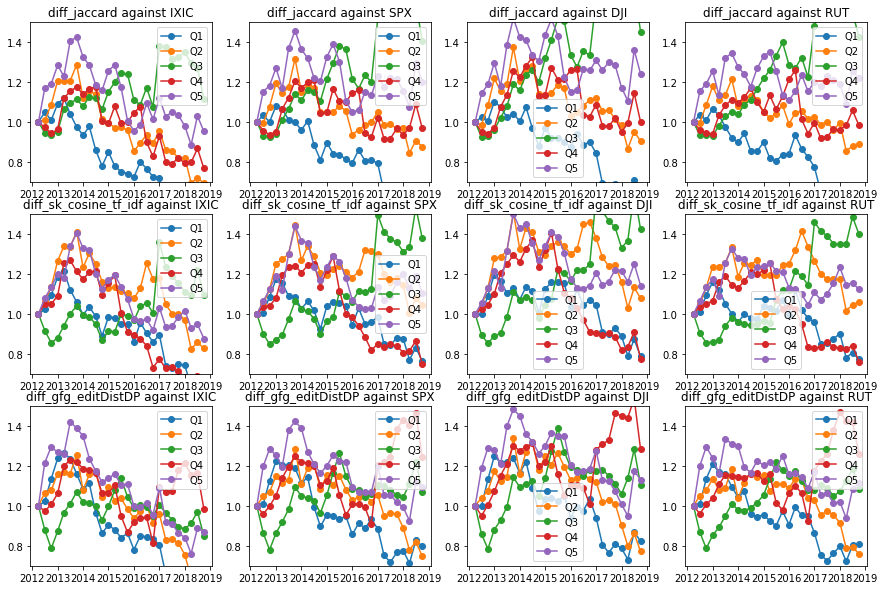

In [50]:
ylim = [0.7, 1.5]
fig, ax = plt.subplots(len(s['diff_metrics']), len(index_data), figsize=(15, 10))
for idx_x, m in enumerate(s['diff_metrics']):
    for idx_y, index_name in enumerate(index_data):
        benchmark, bin_data = display.diff_vs_benchmark_ns(pf_values, index_name, index_data, m, s, norm_by_index=True)
        display.update_ax_diff_vs_benchmark(ax[idx_x, idx_y], benchmark, bin_data, index_name, s, ylim, m)

start = s['time_range'][0]   
end = s['time_range'][1]
plt.savefig(os.path.join(s['path_output_folder'], '{}Q{}_{}Q{}_{}_{}_sw-{}_lem-{}.png'
                         .format(str(start[0])[2:], start[1], 
                                 str(end[0])[2:], end[1],
                                 s['differentiation_mode'][0], s['pf_balancing'][0],
                                 int(s['stop_words']), int(s['lemmatize']))))
if display.run_from_ipython():
    plt.show()
else:
    plt.close(fig)

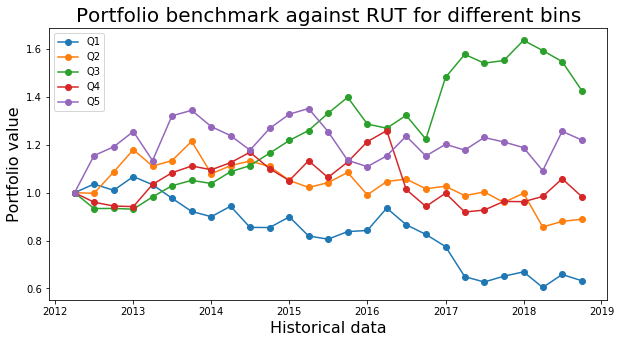

In [51]:
index_name = 'RUT'
diff_method = 'diff_sk_cosine_tf_idf'
diff_method = 'diff_jaccard'
# diff_method='diff_gfg_editDistDP'
benchmark, bin_data = display.diff_vs_benchmark_ns(pf_values, index_name, index_data, diff_method, s, norm_by_index=True)
display.plot_diff_vs_benchmark(benchmark, bin_data, index_name, s)

## For a given ticker

### Metrics vs stock price

In [52]:
cik = 851968
ticker = lookup[cik]
start_date = qtrs.qtr_to_day(s['time_range'][0], 'first', date_format='datetime')
stop_date = qtrs.qtr_to_day(s['time_range'][1], 'last', date_format='datetime')

extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}
#print(extracted_data)
extracted_cik_scores = cik_scores[cik]

In [53]:
extracted_stock_data = {k: v for k, v in stock_data[ticker].items() if start_date <= k <= stop_date}

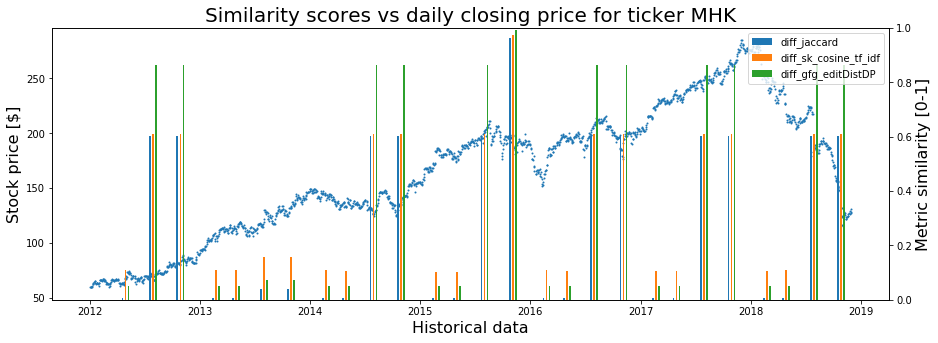

In [54]:
benchmark, metric_data = display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')
display.plot_diff_vs_stock(benchmark, metric_data, ticker, s)

### Sentiment vs stock price

In [55]:
benchmark, metric_data = display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')
display.plot_diff_vs_stock(benchmark, metric_data, ticker, s, method='sentiment')

ValueError: [ERROR] No metrics were computed for method sentiment.